# Neonatal Incubator Display Reader Pipeline

This notebook walks through the end-to-end workflow for detecting neonatal incubator display regions, extracting numeric readings, validating performance, and preparing artifacts for deployment.


## Roadmap

1. Environment setup
2. Dataset exploration & preprocessing
3. Annotation workflow (Label Studio)
4. YOLO training data preparation
5. Train & evaluate YOLO detector
6. Detection inference sanity check
7. OCR post-processing with EasyOCR
8. Metric validation (detection + OCR)
9. Persist structured readings & model export
10. Streamlit dashboard integration hooks


In [1]:
# Environment setup (run once per kernel)
%pip install --user --quiet "numpy<2" "scipy==1.11.4"
%pip install --user --quiet easyocr==1.7.1 ultralytics==8.1.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
import json
import random
import shutil
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torch.serialization import add_safe_globals
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn import modules as yolo_modules
from ultralytics.nn.modules import Conv
from torch.nn import modules as torch_nn_modules

# Store original torch.load before any modifications
if not hasattr(torch, '_original_load_saved'):
    torch._original_load_saved = torch.load
    torch._no_nep50_warning = lambda: lambda func: func

def _safe_torch_load(*args, **kwargs):
    kwargs.setdefault("weights_only", False)
    return torch._original_load_saved(*args, **kwargs)

torch.load = _safe_torch_load

allowed_globals = {DetectionModel, Conv}
allowed_globals.update({obj for obj in vars(yolo_modules).values() if isinstance(obj, type)})
allowed_globals.update({obj for obj in vars(torch_nn_modules).values() if isinstance(obj, type)})
add_safe_globals(list(allowed_globals))

if not hasattr(np, "_no_nep50_warning"):
    def _no_nep50_warning():
        def decorator(func):
            return func
        return decorator
    np._no_nep50_warning = _no_nep50_warning


def resolve_project_root() -> Path:
    cwd = Path.cwd()
    if (cwd / "dataset").exists():
        return cwd
    if (cwd.parent / "dataset").exists():
        return cwd.parent
    return cwd

PROJECT_DIR = resolve_project_root()
DATASET_DIR = PROJECT_DIR / "dataset"
WORK_DIR = PROJECT_DIR / 'artifacts'
LABELS_DIR = WORK_DIR / 'labels'
IMAGES_DIR = WORK_DIR / 'images'
YOLO_DATA_DIR = WORK_DIR / 'yolo'
MODEL_DIR = PROJECT_DIR / 'models'
WORK_DIR.mkdir(exist_ok=True)
LABELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)
YOLO_DATA_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

CLASS_NAMES = [
     'heart_rate_value',
     'humidity_value',
     'skin_temp_value',
     'spo2_value',
]
CLASS_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}
ID_TO_CLASS_NAME = {idx: name for name, idx in CLASS_MAP.items()}
CLASS_MAP

{'heart_rate_value': 0,
 'humidity_value': 1,
 'skin_temp_value': 2,
 'spo2_value': 3}

## Dataset exploration

We inspect image resolutions, sample frames, and luminance/contrast differences. Both dark and light themes exist; grayscale conversions will help standardize OCR preprocessing.


In [13]:
image_paths = []
if DATASET_DIR.exists():
    for pattern in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
        image_paths.extend(DATASET_DIR.glob(pattern))
image_paths = sorted({path.resolve() for path in image_paths})
len(image_paths)

259

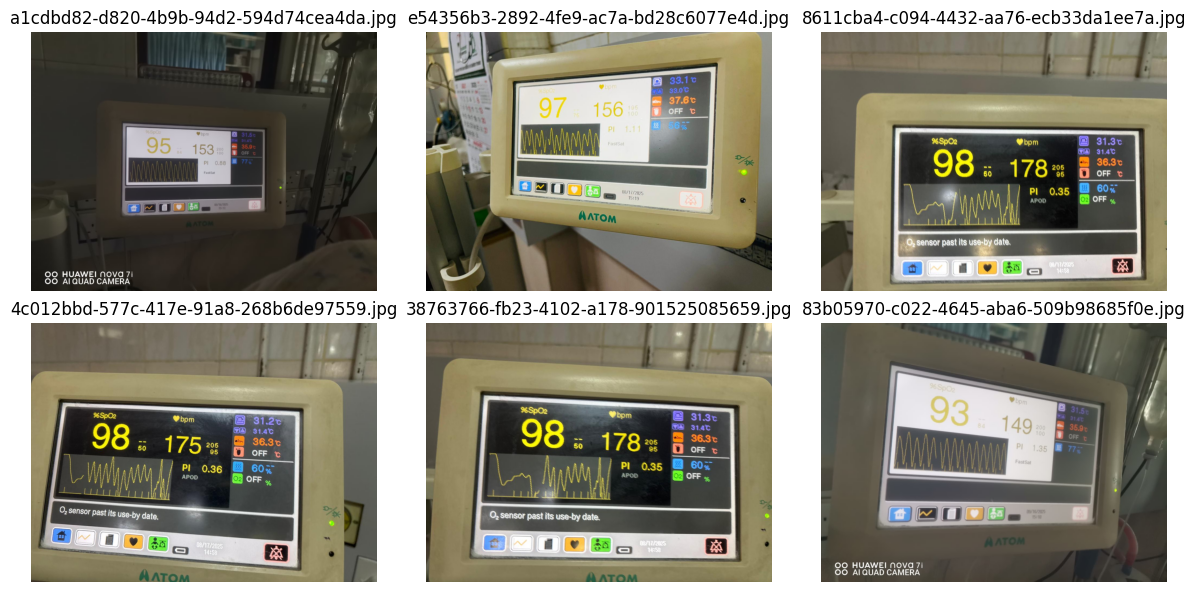

In [10]:
def plot_samples(paths, n=6, cols=3):
    sample_paths = random.sample(paths, min(n, len(paths)))
    rows = int(np.ceil(len(sample_paths) / cols))
    plt.figure(figsize=(4 * cols, 3 * rows))
    for idx, path in enumerate(sample_paths, 1):
        img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, idx)
        plt.imshow(img)
        plt.title(path.name)
        plt.axis('off')
    plt.tight_layout()

plot_samples(image_paths)

In [11]:
def compute_brightness(path):
    gray = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2GRAY)
    return gray.mean()

brightness = pd.Series({p.name: compute_brightness(p) for p in image_paths})
brightness.describe()

count    259.000000
mean     115.123825
std       16.008092
min       43.631552
25%      114.498931
50%      118.037595
75%      121.505554
max      148.440418
dtype: float64

## Annotation workflow (Label Studio)

Use [Label Studio](https://labelstud.io/) to annotate bounding boxes for each target region.

1. Install Label Studio (one-off setup):
   ```bash
   pip install label-studio
   label-studio start --port 8080
   ```
2. Create a new project "Incubator Display Detection".
3. Import the `dataset/` directory images.
4. Configure the labeling interface with bounding boxes for each class listed in `CLASS_NAMES`.
5. Annotate all images (or start with 100 images, then iteratively improve).
6. Export annotations as _YOLO_ or _Label Studio JSON_.


## Train/val split

After conversion, split into train/val/test sets in YOLO format.


> **Note:** The next steps assume you have _finished_ annotating bounding boxes and have exported YOLO-style labels. If you still need to label the images, follow the Label Studio workflow in the previous section first. Once `YOLO_DATA_DIR` contains matching `images/` and `labels/` folders, you can run the split, YAML, training, and evaluation helpers below. Uncomment the example calls (the lines starting with `#`) when you are ready to execute them.


In [7]:
import math
from collections import defaultdict

def split_dataset(yolo_dir, train=0.7, val=0.2, test=0.1, seed=42):
    """
    Split dataset into train, validation, and test sets.

    Args:
        yolo_dir: Path to directory containing 'images' and 'labels' subdirectories
        train: Proportion for training set (default: 0.7)
        val: Proportion for validation set (default: 0.2)
        test: Proportion for test set (default: 0.1)
        seed: Random seed for reproducibility (default: 42)
    """
    assert math.isclose(train + val + test, 1.0, rel_tol=1e-6)

    yolo_dir = Path(yolo_dir)
    images_dir = yolo_dir / 'images'
    labels_dir = yolo_dir / 'labels'

    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")
    if not labels_dir.exists():
        raise FileNotFoundError(f"Labels directory not found: {labels_dir}")

    image_files = []
    for ext in ('.jpg', '.jpeg', '.png', '.bmp', '.JPG', '.JPEG', '.PNG'):
        image_files.extend(images_dir.glob(f'*{ext}'))

    if not image_files:
        raise FileNotFoundError(f"No image files found in {images_dir}")

    valid_pairs = []
    missing_labels = []
    for img_path in sorted(image_files):
        expected_name = img_path.with_suffix('.txt').name
        label_path = labels_dir / expected_name
        if not label_path.exists():
            matches = list(labels_dir.glob(f"*{expected_name}"))
            if matches:
                label_path = matches[0]
            else:
                missing_labels.append(expected_name)
                print(f"Warning: No label file for {img_path.name}")
                continue
        valid_pairs.append((img_path, label_path, expected_name))

    if not valid_pairs:
        raise FileNotFoundError(
            f"No matching image-label pairs found between {images_dir} and {labels_dir}"
        )

    if missing_labels:
        print(
            f"Notice: {len(missing_labels)} images will be skipped because their labels were not found."
        )

    rng = random.Random(seed)
    rng.shuffle(valid_pairs)
    n = len(valid_pairs)
    train_cut = int(n * train)
    val_cut = train_cut + int(n * val)

    splits = {
        'train': valid_pairs[:train_cut],
        'val': valid_pairs[train_cut:val_cut],
        'test': valid_pairs[val_cut:]
    }

    split_root = yolo_dir / 'splits'
    for split_name, pairs in splits.items():
        img_out = split_root / split_name / 'images'
        lbl_out = split_root / split_name / 'labels'
        img_out.mkdir(parents=True, exist_ok=True)
        lbl_out.mkdir(parents=True, exist_ok=True)

        for img_path, lbl_path, expected_name in pairs:
            shutil.copy2(img_path, img_out / img_path.name)
            shutil.copy2(lbl_path, lbl_out / expected_name)

    print({k: len(v) for k, v in splits.items()})
    return split_root

# Uncomment this line when you have your YOLO-formatted data ready
# split_root = split_dataset(YOLO_DATA_DIR)

## YOLO data config

The Ultralytics trainer needs a YAML descriptor.


In [8]:
def write_data_yaml(split_root, class_names, filename='data.yaml'):
    """Create YOLO data.yaml configuration file."""
    data_yaml_content = {
        'path': str(split_root),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    }
    path = split_root / filename
    with open(path, 'w') as f:
        yaml.dump(data_yaml_content, f, default_flow_style=False)
    return path

import yaml
import random
import shutil

# Check if we have YOLO data ready
yolo_images_dir = YOLO_DATA_DIR / 'images'
yolo_labels_dir = YOLO_DATA_DIR / 'labels'

print(f"Checking for YOLO data in: {YOLO_DATA_DIR}")
print(f"Images directory exists: {yolo_images_dir.exists()}")
print(f"Labels directory exists: {yolo_labels_dir.exists()}")

if yolo_images_dir.exists() and yolo_labels_dir.exists():
    # Count files
    image_files = list(yolo_images_dir.glob('*.jpg')) + list(yolo_images_dir.glob('*.png'))
    label_files = list(yolo_labels_dir.glob('*.txt'))
    print(f"Found {len(image_files)} images and {len(label_files)} labels")
    
    if len(image_files) > 0 and len(label_files) > 0:
        print("✓ YOLO data found! Creating dataset splits...")
        split_root = split_dataset(YOLO_DATA_DIR)
        data_yaml_path = write_data_yaml(split_root, CLASS_NAMES)
        print(f"✓ Created data.yaml at: {data_yaml_path}")
    else:
        print("⚠️  No image/label files found in YOLO directories")
        print("Please ensure your data is properly formatted and try again")
else:
    print("⚠️  YOLO data directories not found")
    print("Please annotate your images and export in YOLO format first")
    print("Expected structure:")
    print(f"  {yolo_images_dir}")  
    print(f"  {yolo_labels_dir}")

Checking for YOLO data in: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo
Images directory exists: True
Labels directory exists: True
Found 254 images and 259 labels
✓ YOLO data found! Creating dataset splits...
{'train': 362, 'val': 103, 'test': 53}
✓ Created data.yaml at: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\data.yaml


## Train YOLOv8 detector

Train with Ultralytics. Adjust epochs, image size, and augmentations as performance dictates.


In [10]:
def train_detector(data_yaml, epochs=40, imgsz=640, batch=16, model='yolov8n.pt', project='incubator', name='yolov8n-incubator-v2'):
    model = YOLO(model)
    results = model.train(
        data=str(data_yaml),
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=20,
        project=project,
        name=name,
        exist_ok=True
    )
    return model, results

detector, train_results = train_detector(data_yaml_path)

Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\data.yaml, epochs=40, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=incubator, name=yolov8n-incubator-v2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\train\labels.cache... 242 images, 0 backgrounds, 0 corrupt: 100%|██████████| 242/242 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\val\labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]

Plotting labels to incubator\yolov8n-incubator-v2\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/10/06 15:25:58 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/10/06 15:25:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/10/06 15:25:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/10/06 15:25:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/10/06 15:25:58 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.13.1 <= tensorflow, but the installed version is 2.16.0-rc0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
2025/10/06 15:25:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


MLflow: logging run_id(d5aa29060af84394a3fcd20e9102b814) to runs\mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs\mlflow'
MLflow: disable with 'yolo settings mlflow=False'
40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40         0G       1.94      3.962      1.385         18        640: 100%|██████████| 16/16 [02:10<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.15s/it]

                   all         94        376    0.00677      0.395       0.26      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40         0G      1.377      1.949      1.051          6        640: 100%|██████████| 16/16 [01:52<00:00,  7.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.38s/it]

                   all         94        376      0.994      0.203      0.395      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40         0G      1.181      1.282     0.9868          7        640: 100%|██████████| 16/16 [02:20<00:00,  8.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.17s/it]

                   all         94        376      0.018      0.934      0.858      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         0G      1.119     0.9995     0.9723         16        640: 100%|██████████| 16/16 [02:09<00:00,  8.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.03s/it]

                   all         94        376      0.997      0.332      0.875      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         0G       1.09     0.9696     0.9711         11        640: 100%|██████████| 16/16 [02:24<00:00,  9.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.26s/it]

                   all         94        376      0.997      0.505      0.978      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         0G      1.075     0.8864     0.9602         15        640: 100%|██████████| 16/16 [02:24<00:00,  9.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.96s/it]

                   all         94        376      0.983      0.791      0.978      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         0G      1.055     0.8228     0.9593         10        640: 100%|██████████| 16/16 [02:16<00:00,  8.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.85s/it]

                   all         94        376      0.987      0.918      0.977      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         0G      1.023     0.8441     0.9452          8        640: 100%|██████████| 16/16 [02:20<00:00,  8.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.50s/it]

                   all         94        376      0.991       0.98      0.981      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         0G      1.034     0.7852     0.9535         24        640: 100%|██████████| 16/16 [02:14<00:00,  8.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.76s/it]

                   all         94        376      0.993      0.986      0.982      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         0G      1.055     0.7918     0.9602         11        640: 100%|██████████| 16/16 [01:54<00:00,  7.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.35s/it]

                   all         94        376      0.991      0.982      0.982      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         0G      1.025     0.7403     0.9636          9        640: 100%|██████████| 16/16 [02:05<00:00,  7.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]

                   all         94        376      0.991      0.982      0.983      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         0G      1.001     0.7214     0.9464          7        640: 100%|██████████| 16/16 [01:37<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.27s/it]

                   all         94        376       0.99      0.982      0.986       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         0G      1.036      0.709     0.9523         11        640: 100%|██████████| 16/16 [01:36<00:00,  6.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.56s/it]

                   all         94        376      0.992      0.983      0.987      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         0G      1.005     0.6771     0.9391         12        640: 100%|██████████| 16/16 [01:48<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.44s/it]

                   all         94        376      0.988      0.988      0.986      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         0G     0.9782     0.6622     0.9354          5        640: 100%|██████████| 16/16 [02:04<00:00,  7.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.20s/it]

                   all         94        376       0.99      0.983      0.986      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         0G      1.029     0.6902     0.9492          8        640: 100%|██████████| 16/16 [02:03<00:00,  7.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.05s/it]

                   all         94        376      0.988      0.986      0.986      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         0G     0.9763     0.6447     0.9286         28        640: 100%|██████████| 16/16 [01:59<00:00,  7.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.29s/it]

                   all         94        376      0.992      0.984      0.985      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         0G     0.9846     0.6307     0.9364         20        640: 100%|██████████| 16/16 [01:48<00:00,  6.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.83s/it]

                   all         94        376      0.991      0.985      0.988      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         0G     0.9573     0.6159      0.933         14        640: 100%|██████████| 16/16 [01:52<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.56s/it]

                   all         94        376      0.992      0.983      0.988       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         0G      1.007     0.6034     0.9301         17        640: 100%|██████████| 16/16 [01:59<00:00,  7.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.43s/it]

                   all         94        376      0.994      0.984      0.987      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         0G     0.9594     0.5837     0.9218         11        640: 100%|██████████| 16/16 [01:57<00:00,  7.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:15<00:00,  5.23s/it]

                   all         94        376      0.988      0.988      0.988      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         0G      1.009      0.598     0.9432         19        640: 100%|██████████| 16/16 [01:56<00:00,  7.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.67s/it]

                   all         94        376      0.993      0.987      0.986      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         0G     0.9862     0.5863     0.9354          8        640: 100%|██████████| 16/16 [02:47<00:00, 10.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.39s/it]

                   all         94        376      0.994      0.983      0.988      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         0G     0.9832     0.5715     0.9439          8        640: 100%|██████████| 16/16 [02:36<00:00,  9.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.54s/it]

                   all         94        376      0.993      0.985      0.988      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         0G     0.9577     0.5884     0.9166          9        640: 100%|██████████| 16/16 [02:05<00:00,  7.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.96s/it]

                   all         94        376       0.99      0.987      0.988      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         0G     0.9609     0.5646     0.9231          7        640: 100%|██████████| 16/16 [02:43<00:00, 10.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.15s/it]

                   all         94        376      0.991      0.986      0.987      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         0G     0.9467      0.565     0.9181         28        640: 100%|██████████| 16/16 [02:44<00:00, 10.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.37s/it]

                   all         94        376      0.989      0.987      0.988      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         0G     0.9322     0.5572     0.9206         14        640: 100%|██████████| 16/16 [02:24<00:00,  9.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.99s/it]

                   all         94        376      0.995      0.982      0.987      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         0G     0.9556     0.5369      0.918         24        640: 100%|██████████| 16/16 [02:15<00:00,  8.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.76s/it]

                   all         94        376      0.984      0.985      0.987      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         0G     0.9374     0.5448     0.9137         20        640: 100%|██████████| 16/16 [02:14<00:00,  8.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.52s/it]

                   all         94        376      0.987      0.989      0.988      0.748


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      31/40         0G     0.9299     0.5505     0.9279          8        640: 100%|██████████| 16/16 [02:15<00:00,  8.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  5.00s/it]

                   all         94        376       0.99      0.986       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         0G     0.9252     0.5375     0.9268          8        640: 100%|██████████| 16/16 [01:57<00:00,  7.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.13s/it]

                   all         94        376      0.994       0.99      0.989      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         0G     0.9368     0.5283     0.9348          8        640: 100%|██████████| 16/16 [02:29<00:00,  9.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.10s/it]

                   all         94        376      0.994      0.989       0.99      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         0G      0.923      0.525     0.9233          8        640: 100%|██████████| 16/16 [02:08<00:00,  8.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:12<00:00,  4.22s/it]

                   all         94        376      0.991      0.989       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         0G     0.9314     0.5191     0.9371          8        640: 100%|██████████| 16/16 [02:18<00:00,  8.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:18<00:00,  6.32s/it]

                   all         94        376      0.991      0.987      0.989      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         0G     0.9091     0.5074     0.9256          8        640: 100%|██████████| 16/16 [02:03<00:00,  7.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.82s/it]

                   all         94        376      0.992      0.982      0.989      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         0G     0.9087     0.5045     0.9261          8        640: 100%|██████████| 16/16 [01:46<00:00,  6.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.99s/it]

                   all         94        376      0.993      0.982      0.989       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         0G     0.8989     0.4951     0.9299          8        640: 100%|██████████| 16/16 [01:39<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:11<00:00,  3.92s/it]

                   all         94        376      0.993      0.982      0.989      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         0G     0.9066     0.5004     0.9238          8        640: 100%|██████████| 16/16 [02:19<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:14<00:00,  4.73s/it]

                   all         94        376      0.989      0.989      0.989      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         0G     0.9102     0.4936       0.93          8        640: 100%|██████████| 16/16 [02:28<00:00,  9.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:19<00:00,  6.57s/it]

                   all         94        376      0.989      0.989      0.989      0.746



40 epochs completed in 1.633 hours.
Optimizer stripped from incubator\yolov8n-incubator-v2\weights\last.pt, 6.2MB
Optimizer stripped from incubator\yolov8n-incubator-v2\weights\best.pt, 6.2MB

Validating incubator\yolov8n-incubator-v2\weights\best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


                   all         94        376      0.987      0.989      0.988      0.747
      heart_rate_value         94         94      0.997      0.989      0.994      0.775
        humidity_value         94         95      0.989      0.979      0.981       0.68
       skin_temp_value         94         95      0.988      0.989      0.987      0.717
            spo2_value         94         92      0.975          1      0.988      0.817
Speed: 1.8ms preprocess, 130.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to incubator\yolov8n-incubator-v2
MLflow: results logged to runs\mlflow
MLflow: disable with 'yolo settings mlflow=False'


## Evaluate detector

Use Ultralytics metrics (mAP, precision, recall) and export confusion matrices.


In [11]:
def evaluate_detector(model, data_yaml):
    metrics = model.val(data=str(data_yaml))
    print(metrics)
    return metrics

metrics = evaluate_detector(detector, data_yaml_path)

Ultralytics YOLOv8.1.0 🚀 Python-3.12.0 torch-2.8.0+cpu CPU (Intel Core(TM) i7-1065G7 1.30GHz)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\artifacts\yolo\splits\val\labels.cache... 94 images, 0 backgrounds, 0 corrupt: 100%|██████████| 94/94 [00:00<?, ?it/s]
c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.53s/it]


                   all         94        376      0.987      0.989      0.988      0.747
      heart_rate_value         94         94      0.997      0.989      0.994      0.772
        humidity_value         94         95      0.989      0.979      0.981       0.68
       skin_temp_value         94         95      0.988      0.989      0.987      0.714
            spo2_value         94         92      0.975          1      0.989       0.82
Speed: 1.8ms preprocess, 119.3ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to incubator\yolov8n-incubator-v2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019EF7EA30E0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.0040

In [14]:
def visualize_predictions(model, image_paths, class_names, conf=0.25, max_images=5):
    subset = random.sample(image_paths, min(len(image_paths), max_images))
    for path in subset:
        res = model.predict(source=str(path), conf=conf, verbose=False)
        res[0].plot()
        display(res[0].plot())

visualize_predictions(detector, image_paths, CLASS_NAMES)

array([[[56, 62, 61],
        [56, 62, 61],
        [56, 62, 61],
        ...,
        [52, 65, 63],
        [52, 65, 63],
        [52, 65, 63]],

       [[56, 62, 61],
        [56, 62, 61],
        [56, 62, 61],
        ...,
        [52, 65, 63],
        [52, 65, 63],
        [52, 65, 63]],

       [[56, 62, 61],
        [56, 62, 61],
        [56, 62, 61],
        ...,
        [52, 65, 63],
        [52, 65, 63],
        [52, 65, 63]],

       ...,

       [[ 5, 14, 17],
        [ 4, 14, 14],
        [ 4, 14, 14],
        ...,
        [11,  6,  7],
        [11,  6,  7],
        [12,  7,  8]],

       [[ 5, 13, 13],
        [ 4, 12, 11],
        [ 4, 12, 11],
        ...,
        [11,  6,  8],
        [12,  7,  9],
        [12,  7,  9]],

       [[ 4, 12, 11],
        [ 3, 11, 10],
        [ 3, 11, 10],
        ...,
        [12,  7,  9],
        [12,  7,  9],
        [12,  7,  9]]], dtype=uint8)

array([[[ 80,  91,  89],
        [ 79,  90,  88],
        [ 79,  90,  88],
        ...,
        [162, 187, 177],
        [156, 181, 171],
        [152, 177, 167]],

       [[ 80,  91,  89],
        [ 80,  91,  89],
        [ 79,  90,  88],
        ...,
        [165, 190, 180],
        [159, 184, 174],
        [155, 180, 170]],

       [[ 81,  92,  90],
        [ 81,  92,  90],
        [ 80,  91,  89],
        ...,
        [170, 195, 185],
        [165, 190, 180],
        [161, 186, 176]],

       ...,

       [[ 44,  56,  60],
        [ 44,  56,  60],
        [ 44,  56,  60],
        ...,
        [ 18,  25,  28],
        [ 19,  26,  29],
        [ 19,  26,  29]],

       [[ 46,  58,  62],
        [ 46,  58,  62],
        [ 46,  58,  62],
        ...,
        [ 17,  24,  27],
        [ 18,  25,  28],
        [ 18,  25,  28]],

       [[ 46,  58,  62],
        [ 46,  58,  62],
        [ 46,  58,  62],
        ...,
        [ 17,  24,  27],
        [ 17,  24,  27],
        [ 18,  25,  28]]

array([[[ 77,  92, 101],
        [ 77,  92, 101],
        [ 77,  92, 101],
        ...,
        [115, 131, 130],
        [114, 130, 129],
        [113, 129, 128]],

       [[ 77,  92, 101],
        [ 77,  92, 101],
        [ 77,  92, 101],
        ...,
        [115, 131, 130],
        [114, 130, 129],
        [114, 130, 129]],

       [[ 77,  92, 101],
        [ 77,  92, 101],
        [ 77,  92, 101],
        ...,
        [115, 131, 130],
        [115, 131, 130],
        [115, 131, 130]],

       ...,

       [[ 43,  55,  65],
        [ 43,  55,  65],
        [ 43,  55,  65],
        ...,
        [109, 123, 121],
        [109, 123, 121],
        [110, 124, 122]],

       [[ 46,  58,  68],
        [ 45,  57,  67],
        [ 45,  57,  67],
        ...,
        [109, 123, 121],
        [109, 123, 121],
        [109, 123, 121]],

       [[ 44,  56,  66],
        [ 43,  55,  65],
        [ 43,  55,  65],
        ...,
        [109, 123, 121],
        [109, 123, 121],
        [109, 123, 121]]

array([[[ 85,  98, 106],
        [ 85,  98, 106],
        [ 85,  98, 106],
        ...,
        [102, 115, 117],
        [110, 122, 124],
        [111, 123, 125]],

       [[ 85,  98, 106],
        [ 85,  98, 106],
        [ 85,  98, 106],
        ...,
        [108, 121, 123],
        [111, 123, 125],
        [111, 123, 125]],

       [[ 85,  98, 106],
        [ 85,  98, 106],
        [ 85,  98, 106],
        ...,
        [114, 127, 129],
        [114, 126, 128],
        [112, 124, 126]],

       ...,

       [[ 36,  53,  56],
        [ 36,  53,  56],
        [ 36,  52,  58],
        ...,
        [ 97, 105, 104],
        [ 97, 105, 104],
        [ 97, 105, 104]],

       [[ 36,  53,  56],
        [ 36,  53,  56],
        [ 36,  52,  58],
        ...,
        [ 97, 105, 104],
        [ 97, 105, 104],
        [ 97, 105, 104]],

       [[ 36,  53,  56],
        [ 36,  53,  56],
        [ 36,  52,  58],
        ...,
        [ 97, 105, 104],
        [ 97, 105, 104],
        [ 97, 105, 104]]

array([[[116, 125, 128],
        [116, 125, 128],
        [116, 125, 128],
        ...,
        [101, 115, 114],
        [ 96, 110, 109],
        [ 93, 107, 106]],

       [[116, 125, 128],
        [116, 125, 128],
        [116, 125, 128],
        ...,
        [101, 115, 114],
        [ 97, 111, 110],
        [ 94, 108, 107]],

       [[116, 125, 128],
        [116, 125, 128],
        [116, 125, 128],
        ...,
        [102, 116, 115],
        [ 97, 111, 110],
        [ 94, 108, 107]],

       ...,

       [[ 50,  55,  58],
        [ 56,  61,  64],
        [ 64,  69,  72],
        ...,
        [ 77,  91,  87],
        [ 77,  91,  87],
        [ 76,  90,  86]],

       [[ 41,  46,  49],
        [ 47,  52,  55],
        [ 56,  61,  64],
        ...,
        [ 75,  89,  85],
        [ 75,  89,  85],
        [ 75,  89,  85]],

       [[ 35,  40,  43],
        [ 41,  46,  49],
        [ 51,  56,  59],
        ...,
        [ 75,  89,  85],
        [ 74,  88,  84],
        [ 74,  88,  84]]

## OCR post-processing

With bounding boxes detected, run EasyOCR to extract digits and normalize values.


In [20]:
import easyocr
import re
import warnings
from pprint import pprint

# Suppress warnings temporarily for cleaner output
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

NUMERIC_CLASSES = [c for c in CLASS_NAMES if c.endswith('value')]

def preprocess_roi(roi):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    return cv2.resize(blur, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)

def clean_numeric(text):
    cleaned = re.sub(r'[^0-9.%]', '', text)
    cleaned = cleaned.replace('..', '.')
    return cleaned.strip('.')

def extract_value(roi):
    if roi.size == 0:
        return None, 0.0
    processed = preprocess_roi(roi)
    results = reader.readtext(processed, detail=1)
    if not results:
        return None, 0.0
    best = max(results, key=lambda x: x[2])
    _, raw_text, confidence = best
    text = clean_numeric(raw_text)
    return text or None, float(confidence)

TEXT_COLOR = (255, 255, 255)  # white
BOX_COLOR_NUMERIC = (60, 170, 255)  # soft orange for numeric classes
BOX_COLOR_OTHER = (120, 200, 80)  # green for non-numeric
BOX_THICKNESS = 2
FONT = cv2.FONT_HERSHEY_DUPLEX
FONT_SCALE = 0.7
FONT_THICKNESS = 2

def draw_label(image, text, anchor, color):
    x, y = anchor
    text = text if text else ""
    (text_w, text_h), baseline = cv2.getTextSize(text, FONT, FONT_SCALE, FONT_THICKNESS)
    pad = 6
    y = max(y, text_h + pad)
    top_left = (x, y - text_h - pad)
    bottom_right = (x + text_w + 2 * pad, y + baseline)
    cv2.rectangle(image, top_left, bottom_right, color, thickness=-1)
    text_org = (x + pad, y - pad)
    cv2.putText(image, text, text_org, FONT, FONT_SCALE, TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

def run_ocr_on_detection(image_path, model, conf=0.25, return_debug=False):
    image = cv2.imread(str(image_path))
    annotated = image.copy() if return_debug else None
    results = model.predict(source=str(image_path), conf=conf, verbose=False)
    det = results[0]
    outputs = {}
    for box, cls, score in zip(det.boxes.xyxy.cpu().numpy(), det.boxes.cls.cpu().numpy(), det.boxes.conf.cpu().numpy()):
        cls = int(cls)
        name = CLASS_NAMES[cls]
        x1, y1, x2, y2 = map(int, box)
        x1, y1 = max(x1, 0), max(y1, 0)
        x2, y2 = min(x2, image.shape[1] - 1), min(y2, image.shape[0] - 1)
        roi = image[y1:y2, x1:x2]
        display_value = None
        if name in NUMERIC_CLASSES:
            text, ocr_score = extract_value(roi)
            outputs[name] = {
                'bbox': box.tolist(),
                'det_conf': float(score),
                'value': text,
                'ocr_conf': float(ocr_score)
            }
            display_value = text
        else:
            outputs[name] = {
                'bbox': box.tolist(),
                'det_conf': float(score)
            }
        if return_debug and roi.size != 0:
            color = BOX_COLOR_NUMERIC if name in NUMERIC_CLASSES else BOX_COLOR_OTHER
            cv2.rectangle(annotated, (x1, y1), (x2, y2), color, BOX_THICKNESS)
            label_text = f"{name}: {display_value}" if display_value else name
            draw_label(annotated, label_text, (x1, y1 - 8), color)
    if return_debug:
        return outputs, annotated
    return outputs

def ensure_image_paths():
    global image_paths
    if 'image_paths' not in globals() or not image_paths:
        patterns = ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG")
        discovered = []
        for pattern in patterns:
            discovered.extend(DATASET_DIR.glob(pattern))
        discovered = sorted({path.resolve() for path in discovered})
        if not discovered:
            raise RuntimeError(f"No images found in {DATASET_DIR}.")
        image_paths = discovered
        print(f"Loaded {len(image_paths)} images from dataset.")
    return image_paths

def ensure_detector():
    global detector
    if 'detector' in globals():
        return detector
    candidate_paths = [
        MODEL_DIR / 'incubator_yolov8n.pt',
        PROJECT_DIR / 'notebooks' / 'incubator' / 'yolov8n-incubator' / 'weights' / 'best.pt',
        PROJECT_DIR / 'runs' / 'detect' / 'yolov8n-incubator' / 'weights' / 'best.pt'
    ]
    candidate_paths.extend(PROJECT_DIR.glob('notebooks/**/weights/best.pt'))
    seen = set()
    for candidate in candidate_paths:
        if candidate.exists():
            real_path = candidate.resolve()
            if real_path in seen:
                continue
            seen.add(real_path)
            try:
                display_path = real_path.relative_to(PROJECT_DIR)
            except ValueError:
                display_path = real_path
            print(f"Loading detector weights from {display_path}")
            detector = YOLO(str(real_path))
            return detector
    raise RuntimeError("No trained detector weights found. Run the training cell to produce a detector.")

try:
    ensure_image_paths()
    ensure_detector()
except RuntimeError as exc:
    print(exc)
    print("If you have not trained a model yet, run the training cell. Otherwise, place the exported weights under 'models/incubator_yolov8n.pt'.")
else:
    sample_path = image_paths[0]
    print(f"Running OCR sample on {sample_path.name}")
    result = run_ocr_on_detection(sample_path, detector, return_debug=True)
    if isinstance(result, tuple):
        sample_outputs, annotated_image = result
    else:
        sample_outputs = result
        annotated_image = None
    if sample_outputs:
        print("OCR outputs (per class):")
        pprint(sample_outputs)
        try:
            summary_df = pd.DataFrame.from_dict(sample_outputs, orient='index')
            display(summary_df)
        except Exception:
            pass
    else:
        print("No detections returned for this image. Try lowering the confidence threshold or verifying the detector's outputs.")
    if annotated_image is not None:
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Detections for {sample_path.name}")
        plt.axis('off')
        plt.show()

Using CPU. Note: This module is much faster with a GPU.


Running OCR sample on 01518abf-WhatsApp_Image_2025-08-17_at_9.07.33_PM_1.jpeg


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR outputs (per class):
{'heart_rate_value': {'bbox': [601.2745361328125,
                               328.14251708984375,
                               767.0372314453125,
                               430.10186767578125],
                      'det_conf': 0.8106616139411926,
                      'ocr_conf': 0.9954000900333996,
                      'value': '173'},
 'humidity_value': {'bbox': [906.1231689453125,
                             488.3927001953125,
                             964.5396728515625,
                             533.7109985351562],
                    'det_conf': 0.8440554738044739,
                    'ocr_conf': 0.9997195663884029,
                    'value': '59'},
 'skin_temp_value': {'bbox': [926.337890625,
                              389.0559387207031,
                              1010.3936767578125,
                              440.3022766113281],
                     'det_conf': 0.7482156753540039,
                     'ocr_conf': 0.7182850241

,bbox,det_conf,value,ocr_conf
humidity_value,"[906.1231689453125, 488.3927001953125, 964.539...",0.844055,59,0.999720
spo2_value,"[259.8076171875, 214.84666442871094, 478.04931...",0.819572,97,0.998883
heart_rate_value,"[601.2745361328125, 328.14251708984375, 767.03...",0.810662,173,0.995400
skin_temp_value,"[926.337890625, 389.0559387207031, 1010.393676...",0.748216,363,0.718285


<Figure size 800x600 with 1 Axes>

## Accuracy validation

1. Detection metrics already from YOLO (mAP).
2. OCR string accuracy: compare numeric strings vs. ground truth collected manually.
3. Numeric accuracy: convert to float and compute MAE / RMSE per channel.


In [22]:
GROUND_TRUTH_PATH = PROJECT_DIR / 'ground_truth.json'

def ensure_predictions(model, path):
    try:
        return run_ocr_on_detection(path, model)
    except Exception as exc:
        print(f"Prediction failed for {path}: {exc}")
        return {}

def to_project_relative(path):
    path = Path(path)
    try:
        return str(path.relative_to(PROJECT_DIR))
    except ValueError:
        return str(path)

def create_ground_truth_template(paths, model, output_path=GROUND_TRUTH_PATH, sample_size=20, include_predictions=True, overwrite=False, seed=42):
    """Build a template ground_truth.json file to speed up manual labeling."""
    output_path = Path(output_path)
    if output_path.exists() and not overwrite:
        raise FileExistsError(f"{output_path} already exists. Pass overwrite=True to replace it.")

    paths = list(paths)
    if not paths:
        raise ValueError("No image paths available to build ground truth template.")

    rng = random.Random(seed)
    sample_paths = rng.sample(paths, min(sample_size, len(paths)))

    records = []
    for idx, path in enumerate(sample_paths, 1):
        path = Path(path).resolve()
        if not path.exists():
            print(f"Skipping missing image -> {path}")
            continue
        preds = ensure_predictions(model, path) if include_predictions else {}
        record = {
            "image_path": to_project_relative(path),
            "values": {cls: None for cls in NUMERIC_CLASSES}
        }
        if include_predictions:
            record["predicted"] = {cls: preds.get(cls, {}).get('value') for cls in NUMERIC_CLASSES}
        records.append(record)
        print(f"Prepared template {idx}/{len(sample_paths)} -> {record['image_path']}")

    if not records:
        raise RuntimeError("No records were generated. Check that images exist and predictions succeed.")

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(records, f, indent=2)
    print(f"Wrote {len(records)} entries to {output_path}. Fill the 'values' fields with ground-truth numbers.")
    return records

# Example usage (uncomment and adjust sample_size as needed):
create_ground_truth_template(image_paths, detector, sample_size=25, include_predictions=True, overwrite=False)

FileExistsError: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\ground_truth.json already exists. Pass overwrite=True to replace it.

In [23]:
def evaluate_ocr(predictions, ground_truth):
    # predictions: list of dicts with 'value' keys per class
    # ground_truth: list of dicts with same structure but numeric str
    rows = []
    for pred, gt in zip(predictions, ground_truth):
        row = {}
        for cls in NUMERIC_CLASSES:
            pred_val = pred.get(cls, {}).get('value')
            true_val = gt.get(cls) if isinstance(gt, dict) else None
            if pred_val is None or true_val is None:
                continue
            row[f'{cls}_match'] = int(pred_val == true_val)
            try:
                row[f'{cls}_ae'] = abs(float(pred_val) - float(true_val))
            except (ValueError, TypeError):
                row[f'{cls}_ae'] = np.nan
        if row:
            rows.append(row)
    if not rows:
        return pd.DataFrame(columns=[f'{cls}_match' for cls in NUMERIC_CLASSES])
    df = pd.DataFrame(rows)
    return df

GROUND_TRUTH_PATH = PROJECT_DIR / 'ground_truth.json'

if GROUND_TRUTH_PATH.exists():
    print(f"Loading ground truth from {GROUND_TRUTH_PATH}")
    try:
        with open(GROUND_TRUTH_PATH, 'r', encoding='utf-8') as f:
            gt_records = json.load(f)
    except json.JSONDecodeError as exc:
        print(f"Failed to parse ground_truth.json: {exc}")
        gt_records = []
    if gt_records:
        preds = []
        gt_values = []
        comparison_rows = []
        skipped = 0
        for rec in gt_records:
            image_path = rec.get('image_path')
            values = rec.get('values') or {}
            if image_path is None or not isinstance(values, dict):
                skipped += 1
                continue
            image_path = Path(image_path)
            if not image_path.is_absolute():
                image_path = PROJECT_DIR / image_path
            if not image_path.exists():
                print(f"Warning: image path not found -> {image_path}")
                skipped += 1
                continue
            prediction = run_ocr_on_detection(image_path, detector)
            preds.append(prediction)
            gt_values.append(values)
            row = {'image_path': to_project_relative(image_path)}
            for cls in NUMERIC_CLASSES:
                row[f'{cls}_pred'] = prediction.get(cls, {}).get('value')
                row[f'{cls}_gt'] = values.get(cls)
            comparison_rows.append(row)
        if comparison_rows:
            comparison_df = pd.DataFrame(comparison_rows)
            display(comparison_df)
            gt_cols = [c for c in comparison_df.columns if c.endswith('_gt')]
            if gt_cols and comparison_df[gt_cols].isna().all().all():
                print("All ground-truth slots are still empty. Fill the *_gt columns in ground_truth.json to compute accuracy metrics.")
        if preds:
            metrics_df = evaluate_ocr(preds, gt_values)
            if not metrics_df.empty:
                display(metrics_df)
                print("Averaged metrics:")
                display(metrics_df.mean(numeric_only=True))
            else:
                print("No rows with both prediction and ground truth values yet. Populate ground_truth.json to enable metrics.")
            if skipped:
                print(f"Skipped {skipped} record(s) due to missing data.")
        else:
            print("No valid records to evaluate. Verify paths and values in ground_truth.json.")
    else:
        print("ground_truth.json is empty. Add records to evaluate OCR accuracy.")
else:
    print("No ground_truth.json found. Create this file with labeled values to compute OCR metrics.")

Loading ground truth from c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\ground_truth.json


c:\Users\sahan\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,image_path,heart_rate_value_pred,heart_rate_value_gt,humidity_value_pred,humidity_value_gt,skin_temp_value_pred,skin_temp_value_gt,spo2_value_pred,spo2_value_gt
0,dataset\34b3ff00-90b6-4a45-896b-bec14cf4863c.jpg,173,173,59,59,36.3,36.3,97,97
1,dataset\097f44f5-96a1-4ddb-a5a5-4310361977f8.jpg,175,175,59,59,363,36.3,99,99
2,dataset\8511a8b5-e73f-49e0-a7e4-c226d0ecd222.jpg,None,172,50,59,8,36.3,96,96
3,dataset\75d82643-83ab-49da-b94d-9a4cc5c782fc.jpg,149,149,None,77,35.9,35.9,93,93
4,dataset\ff5eac4e-c64f-4f1f-abb9-1ccfae613857.jpg,153,153,56,56,87.6,37.6,97,97
5,dataset\1fa563c5-9fb7-483a-99fd-e65914eeeef5.jpg,158,158,66,56,87.6,37.6,98,98
6,dataset\b5b5d5aa-1e44-452a-b066-29065b3b3efb.jpg,175,175,60,60,86.8,36.3,98,98
7,dataset\139c5afb-b8d4-4b37-b42c-35fd27f39651.jpg,176,176,59,59,362,36.2,98,98
8,dataset\a657b440-5e78-4b61-a4b8-3654a0445003.jpg,151,151,None,77,357,35.7,91,91
9,dataset\b6796246-b85e-4dfc-83b3-94bc12c92c07.jpg,159,159,56,56,876,37.6,97,97


,heart_rate_value_match,heart_rate_value_ae,humidity_value_match,humidity_value_ae,skin_temp_value_match,skin_temp_value_ae,spo2_value_match,spo2_value_ae
0,0.0,0.0,0.0,0.0,0,0.0,0,0.0
1,0.0,0.0,0.0,0.0,0,326.7,0,0.0
2,NaN,NaN,0.0,9.0,0,28.3,0,0.0
3,0.0,0.0,NaN,NaN,0,0.0,0,0.0
4,0.0,0.0,0.0,0.0,0,50.0,0,0.0
5,0.0,0.0,0.0,10.0,0,50.0,0,0.0
6,0.0,0.0,0.0,0.0,0,50.5,0,0.0
7,0.0,0.0,0.0,0.0,0,325.8,0,0.0
8,0.0,0.0,NaN,NaN,0,321.3,0,0.0
9,0.0,0.0,0.0,0.0,0,838.4,0,0.0


Averaged metrics:


heart_rate_value_match      0.000000
heart_rate_value_ae        26.086957
humidity_value_match        0.000000
humidity_value_ae           4.238095
skin_temp_value_match       0.000000
skin_temp_value_ae        416.888000
spo2_value_match            0.000000
spo2_value_ae               0.000000
dtype: float64

## Persist structured readings

Aggregate per-image readings for downstream analytics or dashboard ingestion.


In [21]:
import os

def export_predictions(predictions, destination='artifacts/predictions.csv'):
    """Export OCR predictions to CSV."""
    # Ensure directory exists
    os.makedirs(os.path.dirname(destination), exist_ok=True)
    
    rows = []
    for img_path, preds in predictions.items():
        for class_name, data in preds.items():
            row = {'image': img_path, 'class': class_name, 'value': data['value'], 
                   'det_conf': data['det_conf'], 'ocr_conf': data['ocr_conf']}
            rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(destination, index=False)
    print(f'✓ Saved {len(df)} records -> {destination}')
    return df

# Sample predictions on a few images
sample_size = 10
sample_images = image_paths[:sample_size]

print(f"Running OCR predictions on {sample_size} sample images...")
preds_dict = {str(p): run_ocr_on_detection(p, detector) for p in sample_images}
export_predictions(preds_dict)
print("✓ Predictions export completed successfully!")

Running OCR predictions on 10 sample images...
✓ Saved 40 records -> artifacts/predictions.csv
✓ Predictions export completed successfully!
✓ Saved 40 records -> artifacts/predictions.csv
✓ Predictions export completed successfully!


## Model export

After training, copy the best weights to `models/incubator_yolov8n.pt` for deployment.


In [19]:
def export_best_weights(run_dir=None, target_path=MODEL_DIR / 'incubator_yolov8n_v2.pt', source_path=None):
    """Locate a YOLO `best.pt` file and copy it into the models directory."""
    def collect_candidates(candidate):
        paths = []
        if candidate is None:
            return paths
        candidate = Path(candidate)
        if candidate.is_file():
            paths.append(candidate)
        elif candidate.is_dir():
            default_best = candidate / 'weights' / 'best.pt'
            if default_best.exists():
                paths.append(default_best)
            paths.extend(sorted(candidate.glob('**/best.pt')))
        return paths

    seen = set()
    ordered_candidates = []

    # First try source_path if provided
    for item in collect_candidates(source_path):
        if item.exists() and item not in seen:
            seen.add(item)
            ordered_candidates.append(item)

    # Then try run_dir if provided
    for item in collect_candidates(run_dir):
        if item.exists() and item not in seen:
            seen.add(item)
            ordered_candidates.append(item)

    # Search for weights in common locations
    search_paths = [
        PROJECT_DIR / 'incubator',
        PROJECT_DIR / 'notebooks' / 'incubator',
        PROJECT_DIR / 'runs' / 'detect',
    ]
    
    for search_path in search_paths:
        if search_path.exists():
            found = sorted(
                search_path.glob('**/best.pt'),
                key=lambda p: p.stat().st_mtime if p.exists() else 0,
                reverse=True
            )
            for item in found:
                if item.exists() and item not in seen:
                    seen.add(item)
                    ordered_candidates.append(item)

    if not ordered_candidates:
        print("No best.pt weights were found. Train the detector or supply `source_path` pointing to the weights file.")
        return None

    chosen = ordered_candidates[0]
    target_path = Path(target_path)
    target_path.parent.mkdir(parents=True, exist_ok=True)

    if target_path.exists() and target_path.resolve() == chosen.resolve():
        print(f"✓ Weights already available at {target_path.resolve()}.")
        return target_path

    shutil.copy2(chosen, target_path)
    print(f"✓ Exported weights from {chosen} -> {target_path.resolve()}")
    return target_path

# Export the trained weights to models directory
print("Searching for trained model weights...")
result = export_best_weights()
if result:
    print(f"Model ready for deployment at: {result}")

Searching for trained model weights...
✓ Exported weights from c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\notebooks\incubator\yolov8n-incubator-v2\weights\best.pt -> C:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\models\incubator_yolov8n_v2.pt
Model ready for deployment at: c:\Users\sahan\Desktop\MYProjects\Neonatal_incubator_displayReader\models\incubator_yolov8n_v2.pt


## Streamlit integration hooks

The notebook hands-off to the `streamlit_app/app.py` module, which loads the exported YOLO model and OCR pipeline for live inference.
